# <font face="Times New Roman">📘Characterizing Time Series Data: Component Analysis and Stationarity Checks.</font>

> <font face="Georgia" color="red"><b>A Tutorital By: Siman Giri</b></font>

## 🛠 <font face="Times New Roman">**Step - 0 - Generate a Sample Time Series:**</font>
<font face="Times New Roman"> First, let's create a synthetic time series with known properties to demonstrate the process. </font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# Set seed for reproducibility
np.random.seed(42)

# Create date range: 4 years of daily data
dates = pd.date_range(start='2019-01-01', end='2022-12-31', freq='D')
t = np.arange(len(dates))

# 1. Define Components
# Trend: Quadratic trend
trend = 0.0005 * (t - 1000)**2 + 10

# Seasonality: Annual (365 days) + Weekly (7 days)
annual_seasonality = 8 * np.sin(2 * np.pi * t / 365)
weekly_seasonality = 3 * np.sin(2 * np.pi * t / 7 + 1)
seasonality = annual_seasonality + weekly_seasonality

# Residuals (Noise + a structural break)
# First half: lower volatility
residuals_1 = np.random.normal(0, 2, size=len(t)//2)
# Second half: higher volatility and a shift (structural break)
residuals_2 = np.random.normal(2, 4, size=len(t) - len(t)//2) # Mean shift + higher variance
residuals = np.concatenate([residuals_1, residuals_2])

# Add an outlier
residuals[500] += 20 # Add a large outlier

# 2. Combine components to create the final series
time_series = trend + seasonality + residuals
ts = pd.Series(time_series, index=dates)
ts.name = "Original Series"

print("Synthetic Time Series Created")
print(f"Start: {ts.index[0]}")
print(f"End: {ts.index[-1]}")
print(f"Length: {len(ts)}")

Synthetic Time Series Created
Start: 2019-01-01 00:00:00
End: 2022-12-31 00:00:00
Length: 1461


## 🏗️ <font face="Times New Roman">**Step - 1 - Plot the Series and Examine Main Features.**</font>

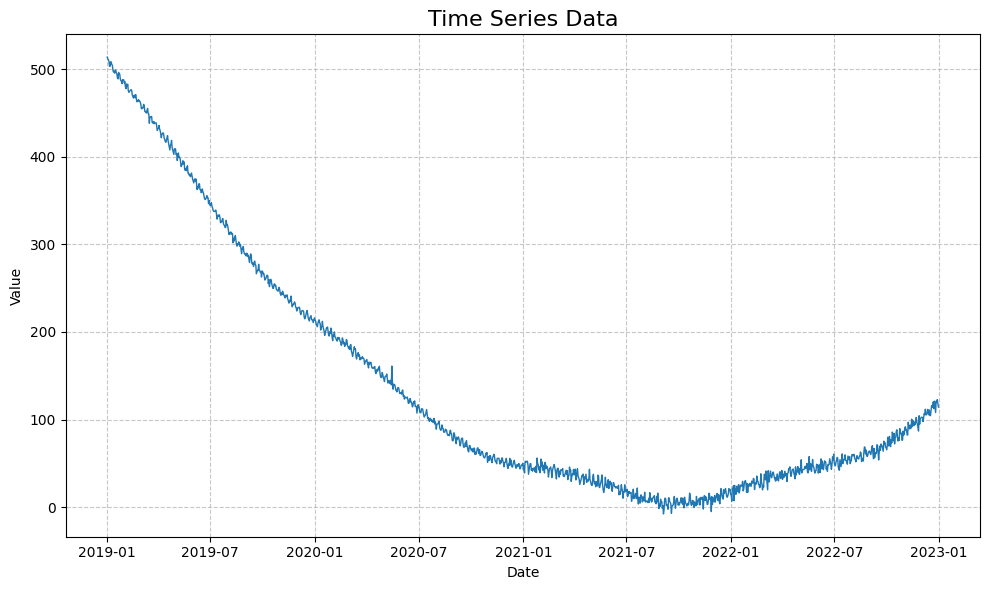

In [ ]:
# Plot the series
plt.figure(figsize=(10, 6))
plt.plot(ts, linewidth=1)
plt.title('Time Series Data', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 📋<font face="Georgia" color="blue"> **Examination of the Graph:**

1.   <font face="Times New Roman" > <b> Trend </b>: A clear, nonlinear (U-shaped) trend is visible. The values decrease initially and then increase.
2.   <font face="Times New Roman"><b> Seasonal/Periodic Components</b>: There are clear, regular oscillations. You can see two patterns:
        
        *   Short-term (High Frequency): Small wiggles repeating every ~7 days (weekly seasonality).
        *   Long-term (Low Frequency): Larger waves repeating over a much longer period (~1 year, annual seasonality).

3.   <font face="Times New Roman"> <b>Sharp Changes in Behavior (Structural Break)</b>: Around the middle of the time period (mid-2020), the nature of the fluctuations seems to change. The "noise" appears to become more volatile, and the mean of the residuals might have shifted. This is the structural break we engineered.</font>
4. <font face="Times New Roman"> <b> Outlying Observation</b>: A single, very sharp spike is visible around early 2020 (this is the outlier we added at index 500).</font>



## 🏗️ <font face="Times New Roman">**Step - 2 - Remove Trend and Periodic Components (Detrending & Deseasonalizing).**</font>
<font face="Times New Roman"> The goal is to isolate the residuals, which should be stationary. Broadly speaking, a time series is said to be stationary if there is:
1.   no systematic change in mean (no trend).
2.   no systematic change in the variance, and
3.   no strictly periodic variations.

</font>

### <font face="Georgia" color="brown"> Method 1 - Using Decomposition (Additive Model):</font>
<font face="Times New Roman"> We assume our series is structured as: <font face="Courier New"><b> Data = Trend + Seasonality + Residual(Noise) </b> </font>

<font face="Times New Roman" color="red"> Cautions: This code uses an automatic decomposition function from stats.model, we do not know how the decomposition is done thus, model is not highly recommended.</font>

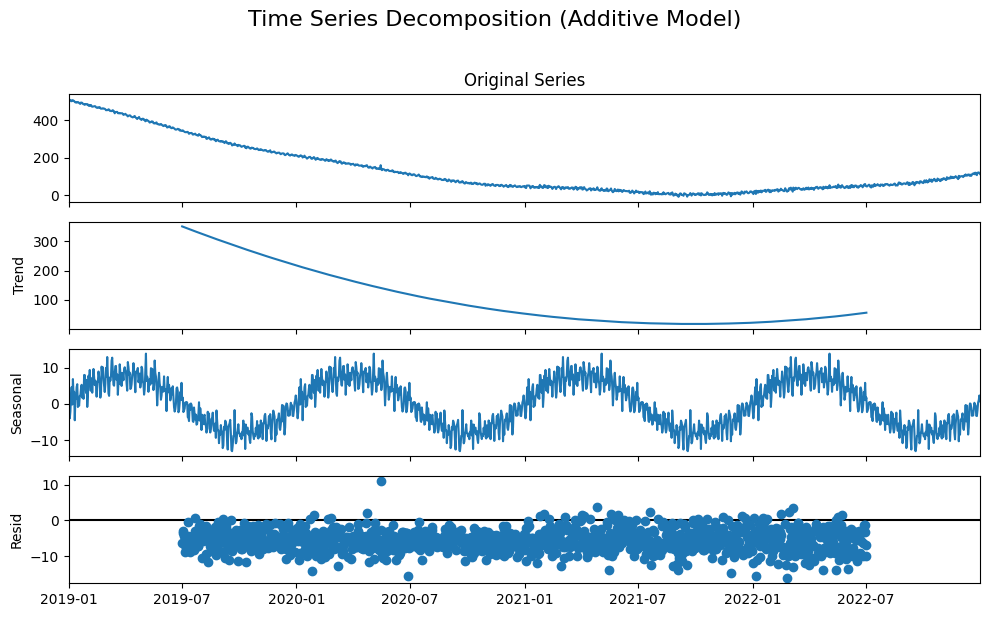

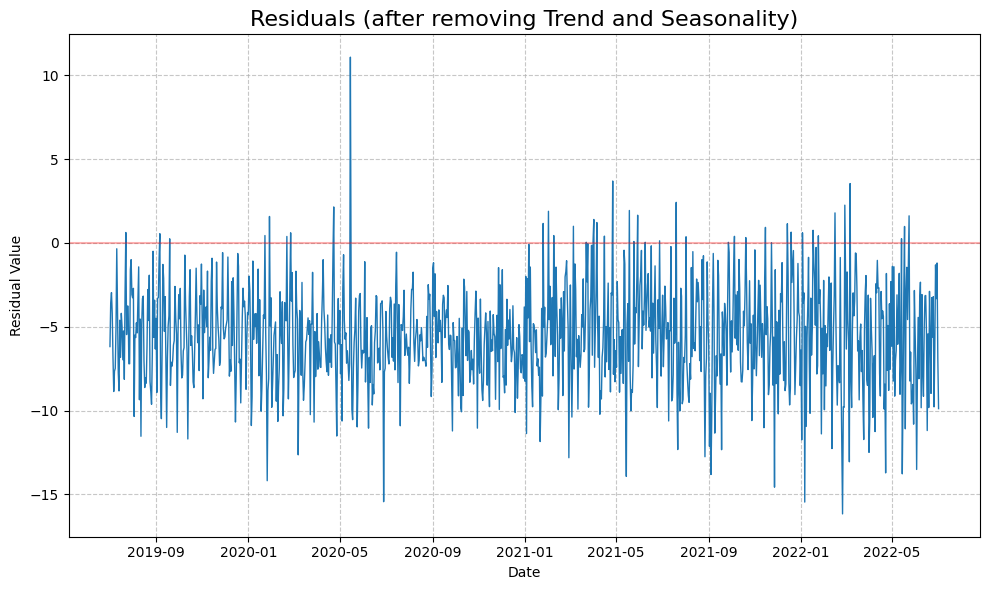

In [ ]:
# Decompose the time series (using an additive model)
decomposition = seasonal_decompose(ts, model='additive', period=365) # Period for annual seasonality

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(10, 6)
plt.suptitle('Time Series Decomposition (Additive Model)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Extract the components
trend_comp = decomposition.trend
seasonal_comp = decomposition.seasonal
residual_comp = decomposition.resid

# The stationary residuals are in `residual_comp`
# We need to drop the NaN values from the ends (introduced by the moving average filters)
stationary_residuals = residual_comp.dropna()

# Let's plot the residuals to check for stationarity
plt.figure(figsize=(10, 6))
plt.plot(stationary_residuals, linewidth=1)
plt.title('Residuals (after removing Trend and Seasonality)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3) # Add a horizontal line at y=0
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 👉<font face="Georgia" color="blue"> Check for Stationarity:</font>
<font face="Times New Roman">


*   <b> Mean: </b> The residuals fluctuate around zero. There might be a slight mean shift mid - way (out structural break), but no consistent upward or downward trend.
*   <b> Variance: </b> The variance appears somewhat constant, though it might be larger in the second half (again due to our structural break). A statistical test like ADF for mean would be better for a real analysis.
* <b> Periodicity: </b> No regular seasonal patterns are left. The decomposition has successfully removed them.

<font face="Times New Roman" color="red"><i>The series of residuals si noe much closer to being stationary and is ready for modeling.</i></font>
</font>

### <font face="Georgia" color="brown"> Method 2 - Differencing:</font>
<font face="Time Series Data"> <b> Core Idea : </b> Instead of modeling the components, we remove them by calculating the difference bwteen consecutive observations. The goal is to use the rate of change rather than hte actual value, which often stabilizes the mean. </font>

<font face="Times New Roman"><b> The Math:</b>

*   First Difference: $Y'_t = Y_t - Y_{t-1}$
*   Second Difference (if needed): $Y''_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) = Y_t - 2Y_{t-1} + Y_{t-2}$
*   Seasonal Difference (for seasonality): $Y'_t = Y_t - Y_{t-p}$ where p is the seasonal period (e.g., p=12 for monthly data with yearly seasonality, p=7 for daily data with weekly seasonality).


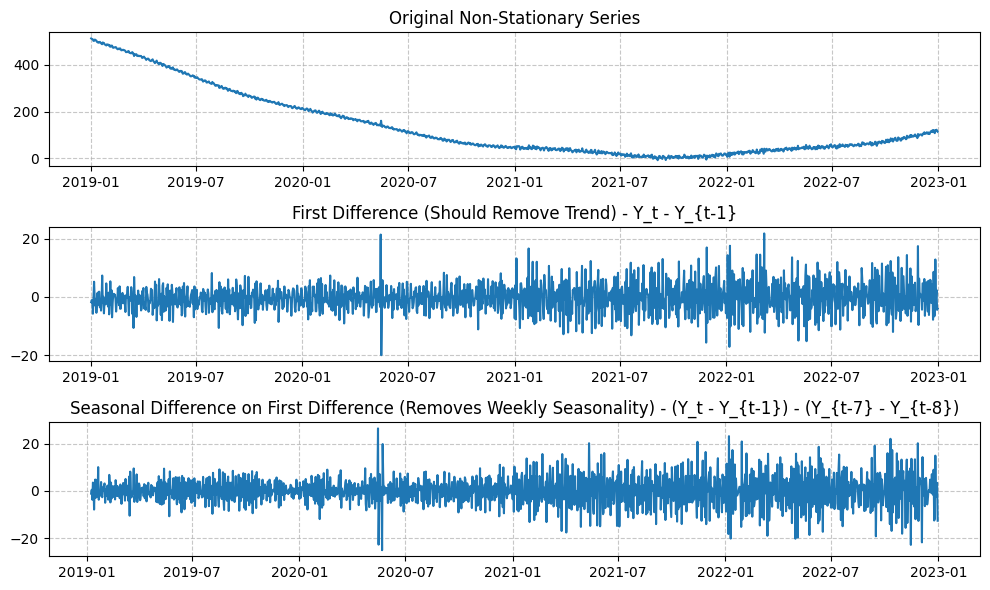

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# (Assuming the synthetic 'ts' series from the previous example is already created)
# If not, run the code from Step 0 in the previous example to generate it.

# Plot the original series
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

# Original Series
axes[0].plot(ts)
axes[0].set_title('Original Non-Stationary Series')
axes[0].grid(True, linestyle='--', alpha=0.7)

# 1. Apply First Difference to Remove Trend
first_diff = ts.diff().dropna() # .diff() calculates Y_t - Y_{t-1}, .dropna() removes the first NaN value

axes[1].plot(first_diff)
axes[1].set_title('First Difference (Should Remove Trend) - Y_t - Y_{t-1}')
axes[1].grid(True, linestyle='--', alpha=0.7)

# 2. Apply Seasonal Difference to the already trend-stationary data to Remove Seasonality
# We know our seasonality has a period of 365 (annual) and 7 (weekly). Let's try weekly first.
seasonal_diff = first_diff.diff(7).dropna() # Seasonal difference of order 7 (weekly)

axes[2].plot(seasonal_diff)
axes[2].set_title('Seasonal Difference on First Difference (Removes Weekly Seasonality) - (Y_t - Y_{t-1}) - (Y_{t-7} - Y_{t-8})')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 👉<font face="Georgia" color="blue"> Interpretation of the Plots:</font>
<font face="Times New Roman">

* <b>Original Series</b>: Clearly non-stationary (has a trend and seasonality).
*   <b>First Difference</b>: The large U-shaped trend is completely gone! The series now oscillates around a stable mean. However, the regular weekly seasonal pattern is still very visible.
*   <b>First + Seasonal Difference</b>: The strong weekly seasonality has now also been drastically reduced. The resulting series looks much more like random noise (stationary).

## 🏗️ <font face="Times New Roman">**Step - 3 - Statistical Check with Augmented Dickey - Fuller Test:**</font>
<font face="Times New Roman"> Statistical Test for stationarity:

*   <b>Null Hypotheis $(H_0)$</b>: series is non - stationary.
*   <b> If p - value < 0.05 $→$ reject $H_0 → $ stationary.

In [ ]:
# Function to run ADF test and print results
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    if result[1] <= 0.05:
        print("-> Strong evidence against the null hypothesis (H0). The series is STATIONARY.")
    else:
        print("-> Weak evidence against the null hypothesis. The series is NON-STATIONARY.")
    print("\n")

# Test all three series
adf_test(ts, 'Original Series')
adf_test(first_diff, 'First Difference')
adf_test(seasonal_diff, 'First + Seasonal (7) Difference')

Augmented Dickey-Fuller Test: Original Series
ADF Statistic: -3.1323
p-value: 0.0243
Critical Values:
   1%: -3.4349
   5%: -2.8636
   10%: -2.5678
-> Strong evidence against the null hypothesis (H0). The series is STATIONARY.


Augmented Dickey-Fuller Test: First Difference
ADF Statistic: -2.1538
p-value: 0.2234
Critical Values:
   1%: -3.4349
   5%: -2.8636
   10%: -2.5678
-> Weak evidence against the null hypothesis. The series is NON-STATIONARY.


Augmented Dickey-Fuller Test: First + Seasonal (7) Difference
ADF Statistic: -15.7664
p-value: 0.0000
Critical Values:
   1%: -3.4349
   5%: -2.8636
   10%: -2.5678
-> Strong evidence against the null hypothesis (H0). The series is STATIONARY.




### 👉<font face="Georgia" color="blue"> Conclusion: Which Method to USe?:</font>


*   <font face="Times New Roman"><b> Use Decomposition (Method 1)</b>: when you need to understand and visualize the individual components (trend, seasonality, residuals). It's intuitive and makes inverting the transformation for forecasts straightforward.
*  <font face="Times New Roman"><b> Use Differencing (Method 2)</b>: when your primary goal is to quickly achieve stationarity for modeling, especially if you plan to use an ARIMA model. ARIMA has differencing built into its "I" (Integrated) component and is designed to work natively with differenced data.


## 🏗️ <font face="Georgia">**Step - 4 - Choose a Model for the Residuals (Using ACF/PACF):**</font>
<font face="Times New Roman"> We use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify potential models (e.g., AR, MA, ARMA).
</font>

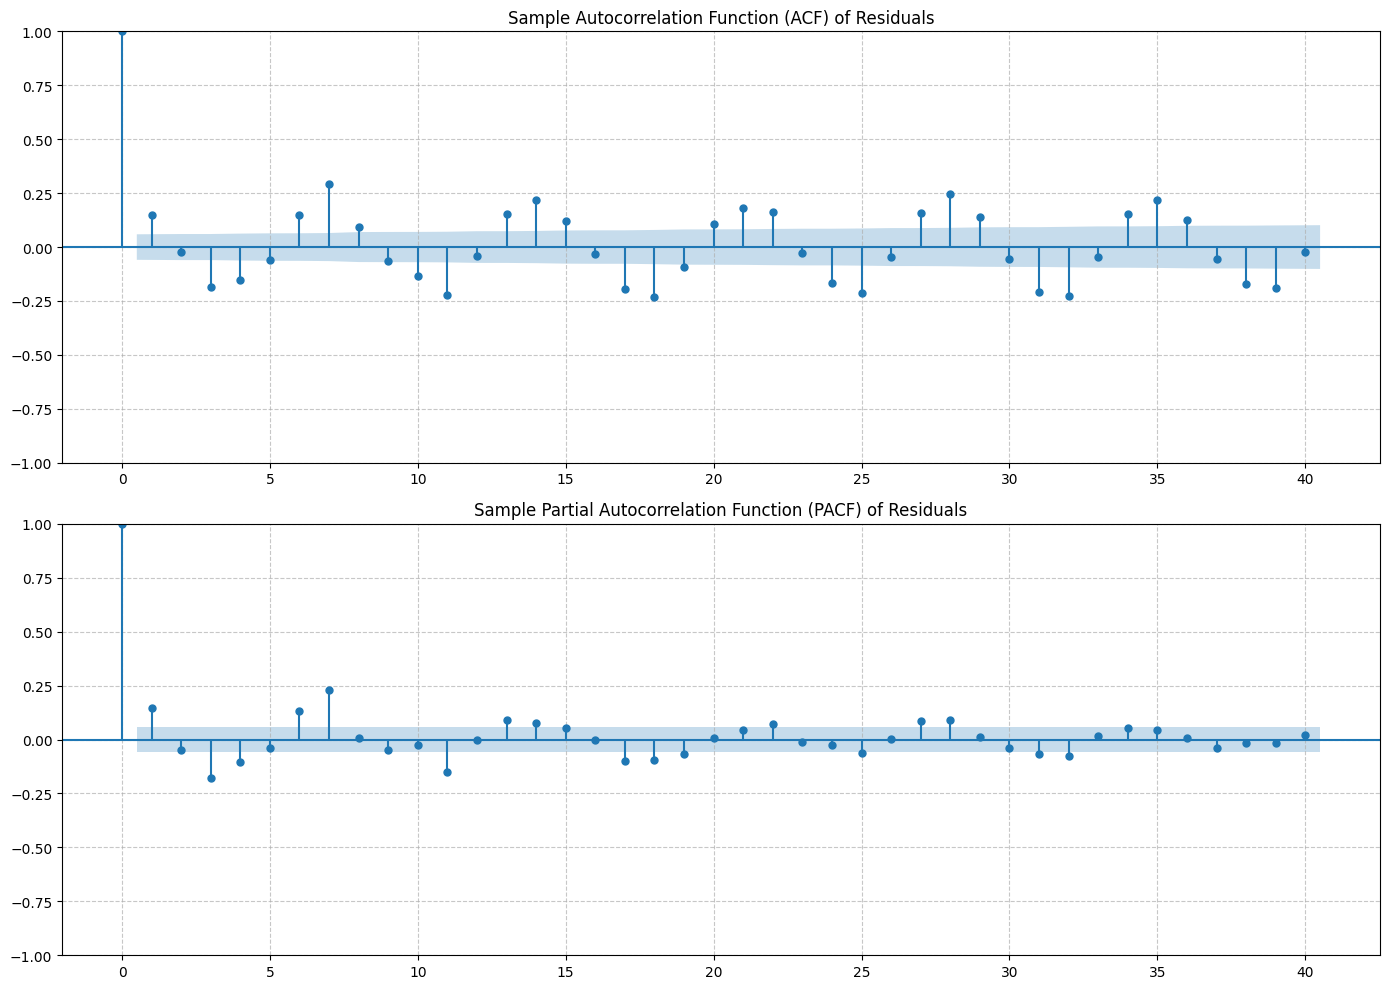

In [ ]:
# Plot ACF and PACF of the stationary residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
plot_acf(stationary_residuals, lags=40, alpha=0.05, ax=ax1, title='Sample Autocorrelation Function (ACF) of Residuals')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot PACF
plot_pacf(stationary_residuals, lags=40, alpha=0.05, ax=ax2, title='Sample Partial Autocorrelation Function (PACF) of Residuals')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 👉<font face="Georgia" color="blue"> Interpreting the ACF/PACF Plots:</font>


*   <font face="Times New Roman"><b> ACF</b>: The autocorrelation shows a few significant lags (e.g., lag 1) and then "cuts off" or decays quickly. This is a classic sign of an Autoregressive (AR) process.
*  <font face="Times New Roman"><b> PACF</b>: The partial autocorrelation has a very significant spike at lag 1, and then no other significant spikes. This strongly suggests an AR(1) model is appropriate for the residuals..
    *   The model for the residuals would be: $ R_t = \phi R_{t-1} + \epsilon_t $
    *   Here $\epsilon_t$ is white noise.
<font face="Times New Roman"><b> Conclusion</b>:  We will fit an ARIMA(1, 0, 0) model to the residuals (which is just an AR(1) model). The "I" (integrated) part is 0 because we've already made the data stationary.

### 🏗️ <font face="Georgia" color="brown">**Ljung - Box Test:**</font>
<font face="Times New Roman"> Instead of testing autocorrelation at each lag, we can apply an overall test by Ljung and Box.</font>

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test on the stationary residuals
# lags: The number of lags to test. A common choice is min(10, n/4) for non-seasonal data,
# or min(2m, n/4) for seasonal data where m is the seasonal period.
# Since we have daily data and removed annual seasonality, let's test up to a reasonable number of lags, say 30.
ljung_box_results = acorr_ljungbox(stationary_residuals, lags=[30], return_df=True)

print("Ljung-Box Test Results on Stationary Residuals:")
display(ljung_box_results)

# Interpretation:
# Null Hypothesis (H0): The residuals are independently distributed (i.e., there is no autocorrelation).
# If p-value < 0.05, reject H0, meaning there is significant autocorrelation remaining.
# If p-value >= 0.05, fail to reject H0, suggesting the residuals are independent (white noise).

Ljung-Box Test Results on Stationary Residuals:


,lb_stat,lb_pvalue
30,797.84967,1.724593e-148


### 👉 <font face="Georgia" color="blue"> Interpreting the Ljing-Box Test:</font>
<font face="Times New Roman">
The Ljung-Box test is a statistical test for checking if there is any significant autocorrelation in the residuals of a time series.

*   **Null Hypothesis ($H_0$)**: The residuals are independently distributed (i.e., there is no significant autocorrelation).
*   **Alternative Hypothesis ($H_a$)**: The residuals are not independently distributed (i.e., significant autocorrelation exists).

From the output of the Ljung-Box test performed on the stationary residuals:

*   **lb\_stat**: This is the Ljung-Box test statistic.
*   **lb\_pvalue**: This is the p-value of the test.

In this case, the p-value (1.7246e-148) is much less than the significance level of 0.05. This means we **reject the null hypothesis ($H_0$)**.

**Conclusion**: There is strong evidence that the residuals are **not** independently distributed, and significant autocorrelation remains in the residuals even after removing the trend and seasonality using decomposition. This suggests that the decomposition method alone was not sufficient to achieve complete stationarity, or that the structural break and outlier are influencing the autocorrelation structure. Further modeling or adjustments might be needed to address this remaining autocorrelation.
</font>

## 🏗️ <font face="Georgia">**Step - 5 - Forecast and Invert the Transforamtions:**</font>
<font face="Times New Roman" color="brown"> <b> 5a $\rightarrow$ Forecast the Residuals:</b>
We will split the data, fit the AR(1) a.k.a ARIMA model on training residuals, and forecast the test period.

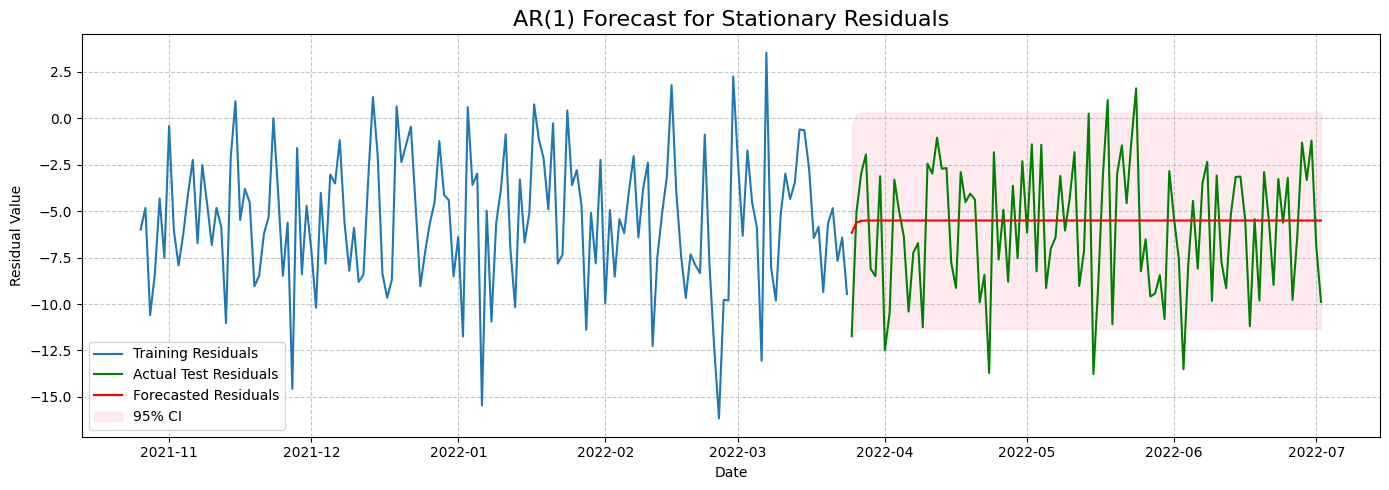

RMSE of Residual Forecast: 3.48


In [ ]:
# Split residuals into train and test (e.g., last 100 days for testing)
train_residuals = stationary_residuals.iloc[:-100]
test_residuals = stationary_residuals.iloc[-100:]

# Fit an AR(1) model on the training residuals
model = ARIMA(train_residuals, order=(1, 0, 0)) # (p, d, q) = (1, 0, 0)
fitted_model = model.fit()

# Forecast the residuals for the test period
residual_forecast = fitted_model.get_forecast(steps=100)
residual_forecast_mean = residual_forecast.predicted_mean
residual_forecast_ci = residual_forecast.conf_int() # Confidence Interval

# Plot the forecast for the residuals
plt.figure(figsize=(14, 5))
plt.plot(train_residuals.index[-150:], train_residuals.values[-150:], label='Training Residuals')
plt.plot(test_residuals.index, test_residuals.values, label='Actual Test Residuals', color='green')
plt.plot(residual_forecast_mean.index, residual_forecast_mean.values, color='red', label='Forecasted Residuals')
plt.fill_between(residual_forecast_ci.index,
                 residual_forecast_ci.iloc[:, 0],
                 residual_forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% CI')
plt.title('AR(1) Forecast for Stationary Residuals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Evaluate the residual forecast (e.g., RMSE)
rmse = np.sqrt(mean_squared_error(test_residuals, residual_forecast_mean))
print(f"RMSE of Residual Forecast: {rmse:.2f}")

<font face="Times New Roman" color="brown"> <b> 5b $\rightarrow$ Invert the Transformations to Forecast the Original Series:</b>

This is the crucial step. To get the forecast for the original series, we add the forecasted residuals back to the trend and seasonal components we previously removed.

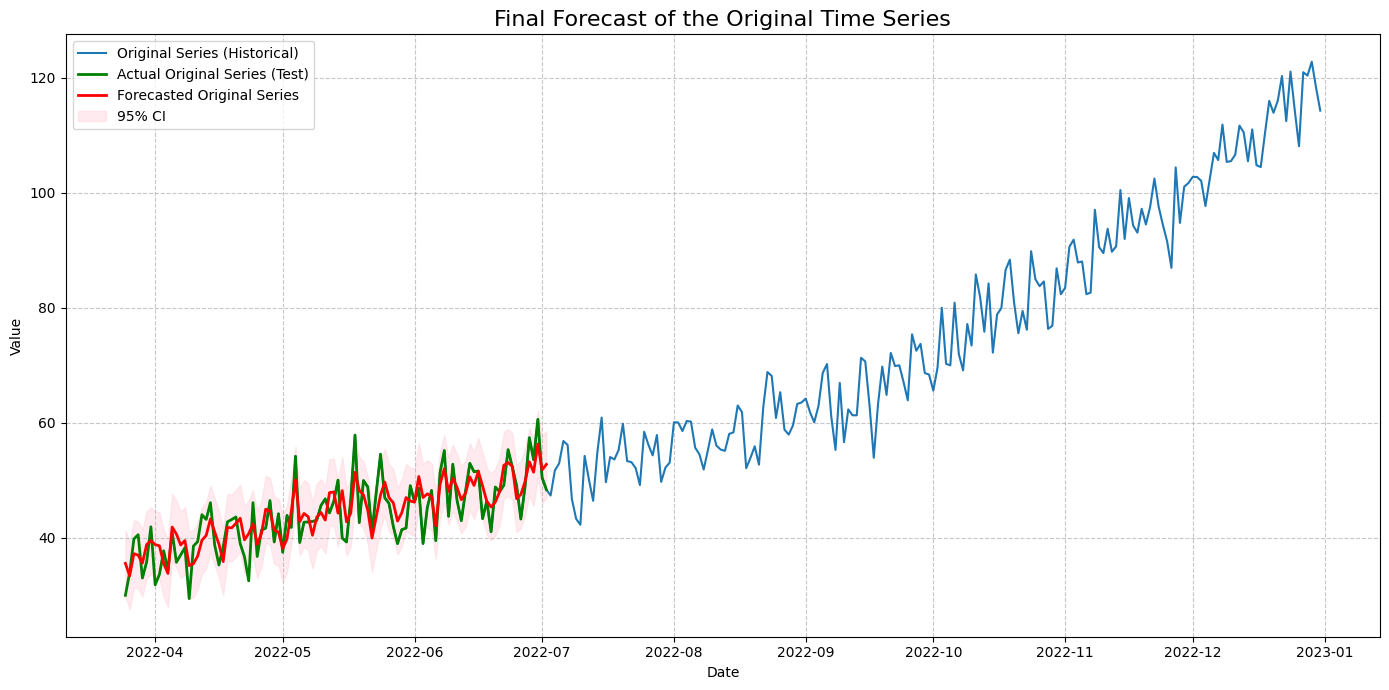

RMSE of Final Original Series Forecast: 3.48


In [ ]:
# 1. For the test period, we need the trend and seasonal components.
# We get these from the decomposition we did earlier.
test_trend = trend_comp[residual_forecast_mean.index]
test_seasonal = seasonal_comp[residual_forecast_mean.index]

# 2. Reconstruct the forecast for the original series:
# Original Forecast = Trend + Seasonality + Residual_Forecast
original_series_forecast = test_trend + test_seasonal + residual_forecast_mean

# 3. Get the actual values of the original series for the test period
actual_original_test = ts[residual_forecast_mean.index]

# 4. Plot the final forecast for the ORIGINAL series
plt.figure(figsize=(14, 7))
plt.plot(ts.index[-250:], ts.values[-250:], label='Original Series (Historical)')
plt.plot(actual_original_test.index, actual_original_test.values, label='Actual Original Series (Test)', color='green', linewidth=2)
plt.plot(original_series_forecast.index, original_series_forecast.values, color='red', label='Forecasted Original Series', linewidth=2)
plt.fill_between(residual_forecast_ci.index,
                 (test_trend + test_seasonal + residual_forecast_ci.iloc[:, 0]),
                 (test_trend + test_seasonal + residual_forecast_ci.iloc[:, 1]),
                 color='pink', alpha=0.3, label='95% CI')
plt.title('Final Forecast of the Original Time Series', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Evaluate the final forecast
final_rmse = np.sqrt(mean_squared_error(actual_original_test, original_series_forecast))
print(f"RMSE of Final Original Series Forecast: {final_rmse:.2f}")

## 🏗️ <font face="Georgia">**Summary:**</font>
<font face="Times New Roman">
This process systematically breaks down a complex time series into its constituent parts, models the stochastic (random) stationary component, and then meticulously reconstructs the forecast. This approach is the foundation of many traditional time series forecasting methods. In modern practice, some of these steps (especially detrending/deseasonalizing) are often handled automatically by models like SARIMAX or STL decompositions, but understanding the underlying principle is fundamental.</font>
